In [1]:
import librosa
import numpy as np
import pandas as pd
import math
import os
import IPython.display as ipd
import pandas as pd

## Dataset folders
data_root = "/homes/alb30/datasets/"
smt_guitar_root = data_root + "IDMT-SMT-GUITAR/"
guitarset_root = data_root + "GuitarSet/"
gpt_root = data_root + "GuitarPlayingTechniques/"

In [2]:
from src.data_preparation import SMTGuitar 
smt_guitar = SMTGuitar(data_root)

In [3]:
data_loaded = smt_guitar.load_data(path='data/')
print(data_loaded[0])
print(data_loaded[1])

Data loaded successfully
True
                 name  lick   mono guitar excitation expression  position  \
0        AR_Lick10_FN    10  False     AR         FS         NO         0   
1        AR_Lick10_KN    10  False     AR         MU         NO         0   
2        AR_Lick10_MN    10  False     AR         PK         NO         0   
3        AR_Lick11_FN    11   True     AR         FS         NO         0   
4        AR_Lick11_KN    11   True     AR         MU         NO         0   
..                ...   ...    ...    ...        ...        ...       ...   
193  LP_Lick9_FN_Lage     9  False     LP         FS         NO         1   
194       LP_Lick9_KN     9  False     LP         MU         NO         0   
195  LP_Lick9_KN_Lage     9  False     LP         MU         NO         1   
196       LP_Lick9_MN     9  False     LP         PK         NO         0   
197  LP_Lick9_MN_Lage     9  False     LP         PK         NO         1   

        fs      len            ms  \
0    441

In [4]:
if not data_loaded[0]:
    smt_guitar.extract_audio()
    smt_guitar.extract_annotations()
    smt_guitar.extract_transcript()

In [5]:
if not data_loaded[0]:
    smt_guitar.get_simple_transcript()
    smt_guitar.save_data(path='data/')

Number of mono clips: 135


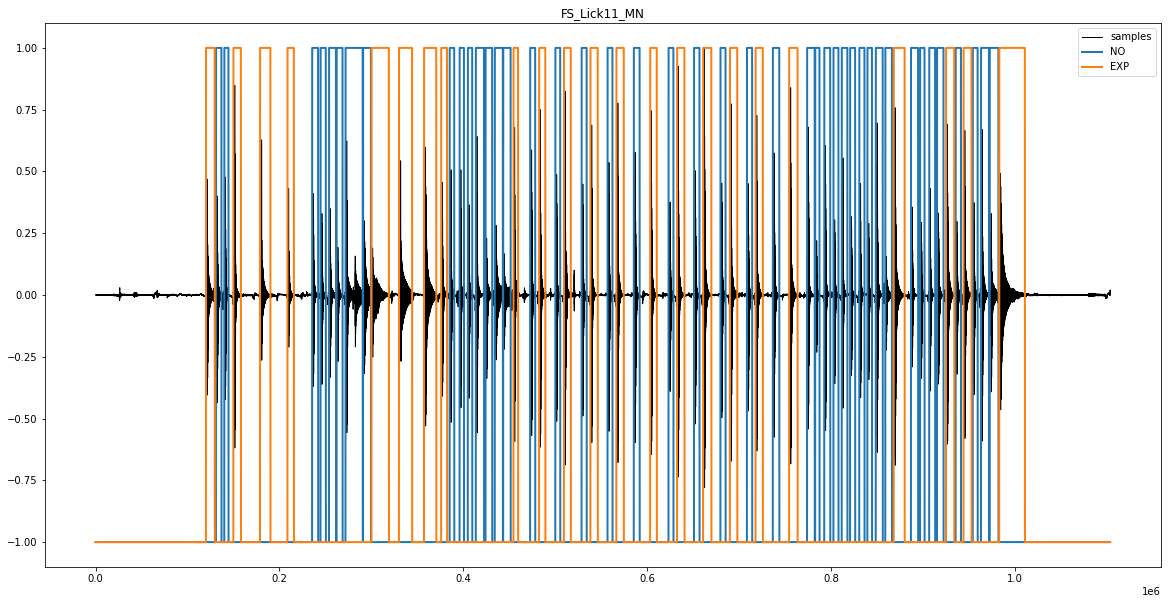

In [6]:
from random import randint
mono_clips = smt_guitar.filter_by({'mono': True})
print("Number of mono clips:", len(mono_clips))
link = mono_clips.sample(n=1) 
idx = link.index[0]
smt_guitar.plot_annotations(idx=idx, simple=True)
ipd.Audio(**smt_guitar.play_data(idx=idx))

In [7]:
bend = smt_guitar.filter_by({'expression': 'BE'})
slide = smt_guitar.filter_by({'expression': 'SL'})
bend_and_slide = pd.concat([bend, slide], axis=1, join='inner')

mono_licks = smt_guitar.filter_by({'mono': True})

import random
el = random.randint(0,len(mono_licks.index))
lick = smt_guitar.get_by_order(el=el, df=mono_licks)
ipd.Audio(**smt_guitar.play_data(idx=lick.name))

In [8]:
idx = 4
array = np.where(smt_guitar.df['transcript'][idx]==1)[0]

# array.unique()
unique_array = np.unique(array)
exp_array = np.array(list(smt_guitar.styles['expression']))
print(exp_array[unique_array], smt_guitar.df['num_exp'][idx])
exp_in_trans = list({key:value for (key,value) in smt_guitar.df['num_exp'][idx].items() if value != 0}.keys())
print(exp_in_trans)

print(set(exp_array[unique_array])==set(exp_in_trans))


['NO' 'BE' 'HA' 'SL' 'VI'] {'NO': 44, 'BE': 13, 'DN': 0, 'HA': 3, 'SL': 2, 'VI': 5}
['NO', 'BE', 'HA', 'SL', 'VI']
True


In [9]:
mono_clips = smt_guitar.filter_by({'mono': True})
print(len(mono_clips))

135


In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
from src.feature_extraction import compute_mel_spectrograms 
import src.utils as utils 
mono_df = smt_guitar.filter_by({'mono': True})
mono_mel_spec_pkl = 'mono_mel_spec.pkl'

# Extract mel spectrograms
mel_loaded, mel_spectrograms = utils.load_dataframe(mono_mel_spec_pkl, path='data/')
# mel_loaded = False
if not mel_loaded:
    print('Compute Mel spectrograms')
    mel_spectrograms = compute_mel_spectrograms(mono_df)
    mel_spectrograms.to_pickle('data/'+mono_mel_spec_pkl)


Data loaded successfully


In [12]:
from src.data_preparation import get_clip_labels 

label_dataframe = get_clip_labels(mono_df, exp=smt_guitar.styles['expression'])

In [13]:
one_hot_labels = np.vstack(label_dataframe['one_hot'].values)
label_encoding = []
for row in one_hot_labels:
    label_encoding.append(pd.DataFrame(row))
print(len(label_encoding))
print(label_encoding[0])

135
   0
0  1
1  1
2  0
3  1
4  1
5  1


In [14]:
from src.feature_extraction import zero_pad_spectrograms 

spectrograms = zero_pad_spectrograms(mel_spectrograms)

In [15]:
print(len(spectrograms))
# print(spectrograms[0]['spectrogram'].values)
print(type(spectrograms[0].values), spectrograms[0].values.shape)
print(type(spectrograms[0].values[0][0]), spectrograms[0].values[0][0].shape)

6
<class 'numpy.ndarray'> (135, 1)
<class 'numpy.ndarray'> (782, 128)


In [16]:
from sklearn.model_selection import train_test_split

## Create train and test sets
train_sets = list()
test_sets = list()

X_train, X_test, y_train, y_test = train_test_split(spectrograms[0], np.array(one_hot_labels))

train_sets.append(X_train)
test_sets.append(X_test)

test_indices = X_train.index
train_indices = X_test.index

for spec in spectrograms[1:]:
        train_sets.append(pd.DataFrame(spec, index=train_indices))
        test_sets.append(pd.DataFrame(spec, index=test_indices))

print(len(train_sets))
print(train_sets[0])

# n_features = X_train.shape[2]
# n_time = X_train.shape[1]
print('Num features', X_train.values[0][0].shape[1])
print('Num frames', X_train.values[0][0].shape[0])

6
                                                     0
4    [[7.045021e-05, 0.00021217002, 0.00036292642, ...
3    [[5.0305054e-05, 7.819824e-05, 0.00010835537, ...
52   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
40   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
112  [[0.00048101298, 0.0045317095, 0.008803367, 0....
..                                                 ...
111  [[6.079655e-06, 4.8636208e-05, 9.3694114e-05, ...
37   [[0.00038401858, 0.00037722624, 0.00037555795,...
87   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
115  [[0.0, 6.7949063e-06, 1.394739e-05, 8.344647e-...
116  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

[101 rows x 1 columns]
Num features 128
Num frames 782


In [17]:
from sklearn.preprocessing import StandardScaler

def standardize(feat, scaler=None):
    if scaler is None:
        scaler = StandardScaler().fit(feat)
    out = scaler.transform(feat)
    return out, scaler


In [18]:
# Weights for balancing classes
n_samples = one_hot_labels.shape[0]
n_classes = one_hot_labels.shape[1]
weights = n_samples / (n_classes * np.sum(one_hot_labels, axis=0))
print(weights)

[0.16666667 0.5        0.83333333 0.625      0.5        0.5       ]


In [19]:
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input

Using TensorFlow backend.


In [20]:

print(len(X_train.values))

101


In [70]:
n_features = X_train.values[0][0].shape[1]
n_frames = X_train.values[0][0].shape[0]

input_shape = (n_features, n_frames, 1)
print('Input shape', input_shape)

inputs = []
for i, ts in enumerate(train_sets):
    name = 'input_'+str(i)
    inputs.append(Input(input_shape, name=name))
    

Input shape (128, 782, 1)


In [87]:
from src.models import *

In [88]:
ws=[512, 1024, 2048, 4096, 8192, 16384]

early_convolutions = []
ec_outputs = []
for idx, inpt in enumerate(inputs):
    early_convolutions.append(EarlyConvolution(inpt, name=str(ws[idx])+'_'))
    early_convolutions[idx].define_layers()
    ec_outputs.append(early_convolutions[idx].output_layer)

In [89]:
late_convolution = LateConvolution(input_layers=ec_outputs)
lc_output = late_convolution.define_layers()

In [92]:
model = Model(inputs=inputs, outputs=lc_output)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.summary() 

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 782, 1)  0                                            
___________________________________________________________________________________________

In [91]:
recurrent = Recurrent(input_layer=lc_output, seq_len=n_frames)
re_output = recurrent.define_layers()

ValueError: total size of new array must be unchanged

In [ ]:
classifier = Classifier(input_layer=re_output)
cl_output = classifier.define_layers()

In [86]:
model = Model(inputs=inputs, outputs=classifier.output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.summary() 
weights = model.layers[6].get_weights()
# print(model.layers[6].name)
# print(np.array(weights).size)
# print(len(weights[0]))


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 782, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 782, 1)  0                                            
___________________________________________________________________________________________

In [77]:
def load_theano_model(fp):
    with np.load(fp) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    return param_values

clip2frame_model_path = 'models/model.20160309_111546.npz'
c2f_model = load_theano_model(clip2frame_model_path)

In [52]:
npzfile = np.load('models/model.20160309_111546.npz')

In [53]:
# print(npzfile.files)
# print(npzfile['arr_0'].shape)
for f in npzfile.files:
    print(f, npzfile[f].shape)
    


arr_24 (512, 192, 1, 1)
arr_25 (512,)
arr_26 (512, 512, 1, 1)
arr_27 (512,)
arr_20 (32, 1, 8, 128)
arr_21 (32,)
arr_22 (32, 32, 8, 1)
arr_23 (32,)
arr_28 (188, 512, 1, 1)
arr_29 (188,)
arr_30 (188,)
arr_19 (32,)
arr_18 (32, 32, 8, 1)
arr_11 (32,)
arr_10 (32, 32, 8, 1)
arr_13 (32,)
arr_12 (32, 1, 8, 128)
arr_15 (32,)
arr_14 (32, 32, 8, 1)
arr_17 (32,)
arr_16 (32, 1, 8, 128)
arr_1 (32,)
arr_0 (32, 1, 8, 128)
arr_3 (32,)
arr_2 (32, 32, 8, 1)
arr_5 (32,)
arr_4 (32, 1, 8, 128)
arr_7 (32,)
arr_6 (32, 32, 8, 1)
arr_9 (32,)
arr_8 (32, 1, 8, 128)


In [ ]:
# print(c2f_model)
print(type(c2f_model))
for l, p in enumerate(c2f_model):
    print(l, len(p))


In [ ]:
def extract_mbe(_y, _sr, _nfft, _nb_mel):
    spec, n_fft = librosa.core.spectrum._spectrogram(y=_y, n_fft=_nfft, hop_length=_nfft//2, power=1)
#     spec = np.abs(librosa.stft(y=_y, n_fft=_nfft, hop_length=_nfft//2))
    mel_basis = librosa.filters.mel(sr=_sr, n_fft=_nfft, n_mels=_nb_mel)
    return np.log(np.dot(mel_basis, spec))

In [ ]:
import random
el = random.randint(0,len(mono_licks.index))
lick = smt_guitar.get_by_order(el=el, df=mono_licks)

In [ ]:
samples = lick['samples']
fs = lick['fs']
re_samples = librosa.resample(samples, fs, 16000)

mbe = extract_mbe(_y=re_samples, _sr=16000, _nfft=512, _nb_mel=128)

In [ ]:
print(mbe.shape)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(mbe)
data_in=X_train
shape=(data_in.shape[-2], data_in.shape[-1])
